# Current-Based Spiking Neural Network (current-SNN)

Spike-coding network based on the paper by Barret et al. (2016). Full citation:

Barrett, D. G., Deneve, S., & Machens, C. K. (2016). Optimal compensation for neuron loss. Elife, 5, e12454.

## Install required packages

Install required packages

In [1]:
import numpy as np
import pylab as pl
import math
from matplotlib import colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import sweep_poly
from scipy.ndimage.filters import gaussian_filter1d
import random
import os
import matplotlib.animation as animation
import copy

## Functions used for simulation

### Initialize weights

Initialize weights

In [72]:
def initialize_weights(N, d):
    """ Initialize decoding weights of the different neurons. 
    
    Parameters
    ----------
    N : int
        number of neurons
    d : int
        number of dimensions
    
    Returns
    ----------
    D : 1D-array
        weights per dimension, size (N, d)
    
    """

    if d == 2:
        # 2-dimensional input signal
        
        weights = np.linspace(0, 2 * np.pi, N + 1)       
        D = np.zeros((N,d))
        D[:, 0] = [np.sin(weight) for weight in weights[0:N]]
        D[:, 1] = [np.cos(weight) for weight in weights[0:N]]
        
    else:
        D = np.random.normal(0, 0.4, size=(N, d))
        
    D = np.asarray(D).reshape((N, d))
               
    return D

### Initialize parameters

Initialize parameters

In [73]:
def initialize_params(N, d, dt, iterations, D, beta):
    """ Initialize variables and parameters. 
    
    Parameters
    ----------
    N : int
        number of neurons
    d : int
        number of dimensions
    dt : int
        time step
    iterations : int
        length of the simulation
    beta : int
        cost
    weight : string, optional
        all neurons have same weights ("homogeneous") or neurons have different weights ("heterogeneous")
    gamma : int, optional
        read-out weight of the neurons (only applies when weights="homogeneous")
        
    Returns
    ----------
    t : 1D-array
        timesteps
    x_est : 1D-array
        input estimate per timestep, size (d, iterations)
    o : array
        spike trains, with value 0 if there is no spike and value 1/dt if there is a spike,
        size (N, iterations) 
    voltage : array
        voltages, size (N, iterations) 
    T : 1D-array
        threshold of the neurons
    
    """
    
    # timesteps
    t = np.arange(0, iterations) * dt

    # voltage
    voltage = np.zeros((N, iterations))

    # input estimate
    x_est = np.zeros((d, iterations))

    # spike train
    o = np.zeros((N, iterations))

    # threshold
    T = [(np.dot(weight, weight) + beta)/2 for weight in D]

    return (t, voltage, x_est, o, T)

### Time varying signal

Create time varying signal

In [75]:
def time_varying_signal(d, positive_signal=False):
    """ Initialize time varying, sinusoidal input signal. 

    Parameters:
    d: int
        number of dimensions
    positive: boolean, optional
        positive input signal only (True) or not (False)
    
    Returns
    ----------
    x : array
        input per timestep, size (d, iterations)
    c : array
        sum of the input and input derivative per timestep, size (d, iterations)
        
    """
    
    c = []
    x = []
    
    # number of sinus periods (total # of sinus periods = 2 * cycles)
    cycles = 2
    t = np.linspace(0, np.pi, d + 1)       # starting points of d-dimensioan sinusoidal input signals
    
    for i in range(d):
        
        # create input signal
        x_temp = []
        if positive_signal == True:
            x_temp = np.sin(2 * np.linspace(-cycles * np.pi, cycles * np.pi, iterations) + t[i]) + 2
        else:
            x_temp = np.sin(2 * np.linspace(-cycles * np.pi, cycles * np.pi, iterations) + t[i])
        
        # compute derivative
        dxdt = np.diff(x_temp)/dt
        c_temp = x_temp[:-1] + dxdt

        c.extend(c_temp)
        x.extend(x_temp)

    c = np.asarray(c).reshape((d, iterations - 1))
    x = np.asarray(x).reshape((d, iterations))

    return(c, x)

In [5]:
def time_varying_signal_plateau(c_upp=1):
    """ Initialize time varying input signal with a plateau. 
    
    Parameters
    ----------
    c_upp : int, optional
        value of the plateau
    
    Returns
    ----------
    x : 1D-array
        input per timestep
    c : 1D-array
        sum of the input and input derivative per timestep
        
    """
        
    c = []
    
    # create time-varying signal
    x_t = np.ones((d, iterations)) * c_upp

    step = 150
    x_t[:, 0:step] = 0
    x_t[:, iterations - 2 * step:iterations] = 0

    x = gaussian_filter1d(x_t, sigma=20) # smooth signal
        
    for i in range(d):
        dxdt = np.diff(x[i,:])/dt
        c.extend(x[i, :-1] + dxdt)
        
    c = np.asarray(c).reshape((d, iterations - 1))
    x = np.asarray(x).reshape((d, iterations))
    
    return (c, x)

### Run simulation

In [76]:
def run(tau, beta):
    """ Run simulation of spike coding network. At each time step, the voltage and input estimate is computed
    using the Euler's method. The network follows a spike rule that if one of the voltage reaches threshold the
    network outputs a spike wherafter the voltages and input estimate are updated. 
    
    Parameters
    ----------
    
    tau : int
        time constant
    beta : int
        cost
    
    """
    
    for t in range(1, iterations):

        # update input estimate
        dxestdt = (-1/tau) * x_est[:, t - 1] + np.dot(D.T, o[:, t - 1])
        x_est[:, t] = x_est[:, t - 1] + dt * dxestdt

        # update voltages
        dVdt = (-1/tau) * voltage[:, t - 1] + np.dot(D, c[:,t - 1]) - np.dot(np.dot(D, D.T) + np.identity(N) * beta, o[:, t - 1])
        voltage[:, t] = voltage[:, t - 1] + dt * dVdt

        # check for neurons with voltages above threshold
        neurons = np.arange(0, N, 1)
        above_threshold = neurons[np.where(voltage[:, t] > T)]

        # reset neurons' voltages when threshold is exceeded
        if len(above_threshold) > 0:

            # select spiking neuron
            spike_neuron = np.random.choice(above_threshold)
            
            # update spikes
            o[spike_neuron, t] = 1/dt

### Visualize results

Functions used to visualize results

In [7]:
def zero_to_nan(values):
    """Replace every 0 with 'nan' and return a copy.
    
    Parameters
    ----------
    spike_trains : array
        spike trains of the different neurons
    
    Returns
    ----------
    o_Nan : array
        array where every 0 is replaced by NaN, size (spike_trains.shape)
        
    """
    
    return [float('nan') if x==0 else x for x in values]

In [58]:
def visualize(color, plot_voltage=True, plot_c=False):
    """ Visualize results of the simulation of the spike coding network. Return one plot with the input and input estimate,
    one plot with the spike trains, and N plots for the voltages.
    
    Parameters
    ----------
    color : array
        RGB values for the different neurons, size (N, 3)
    plot_voltages : boolean, optional
        voltages are plotted (True) or not (False)
    plot_c : boolean, optional
        sum of input plus input derivative is plotted (True) or not (False)
    
    """ 
    
    # initialize plots
    if plot_voltage == 1:
        plot = d + N + 1
    else:
        plot = d + 1
    pl.subplots(plot, 1, figsize=(12, 16))
    pl.subplots_adjust(hspace=0.2 * N)
    counter = 1
    pl.rc('text', usetex=True)
       
    # plot input and input estimate
    for i in range(1, d + 1):
        pl.subplot(plot, 1, counter)
        pl.plot(t, x_est[i - 1,:], label=r'$\hat{x}_{%i}$' %i, color='gray')
        pl.plot(t, x[i - 1,:], label='$x_{%i}$' %i, color='k')
        if plot_c == True:
            pl.plot(t[:-1], c[i - 1, :], '--k', label=r'$x + \dot{x}$', alpha=0.2)
        pl.legend()
        counter = counter + 1
    
    # plot spike trains
    fig = pl.subplot(plot, 1, counter)
    for i in range(1, N + 1):
        values = zero_to_nan(o[i - 1, :] * i)
        pl.scatter(t, values, color=color[i - 1][:]/255, label='N%i' %i, s=1.5)
    pl.title('Spike train', fontsize=15)
    pl.yticks([])
    pl.xticks([])
    pl.xlim(0, iterations * dt)
    pl.legend()
    counter = counter + 1

    # plot voltage per neuron over time
    if plot_voltage == 1: 
        for i in range(1, N + 1):
            pl.subplot(plot, 1, counter)
            pl.plot(t, voltage[i - 1], color=color[i - 1][:]/255, label='voltage')
            pl.plot(t, np.ones(iterations) * T[i - 1], color='gray', label='threshold')
            pl.xlim(0, iterations * dt)
            pl.ylabel('Voltage')
            pl.title('Neuron %i' %i,  fontsize=15)
            pl.legend()
            counter = counter + 1
        
    pl.xlabel('time')

## Other functions

### Decoding weights

In [134]:
def plot_weights():
    """ Plot the weights for N neurons (2D and 3D input signal). """
        
    if d == 2:
    # 2-dimensional input signal
        
        plots = 2
        pl.subplots(plots, 1) # figsize=(12, 4)
        
        pl.axhline(y=0, color='k', alpha=0.6)
        pl.axvline(x=0, color='k', alpha=0.6)
   
        # plot weights as arrows
        pl.subplot(1, 2, 1)
        pl.axis('square')
        for i in range(1, N + 1):
            arrow = pl.arrow(0, 0, D[i - 1, 0], D[i - 1, 1], color=color[i - 1][:]/255, head_width=0.1)
        pl.xlabel('D1')
        pl.ylabel('D2')
        pl.title('Weights')
        pl.xlim(-1.5, 1.5)
        pl.ylim(-1.5, 1.5)

        # plot weights as points
        pl.subplot(1, 2, 2)
        pl.axis('square')
        for i in range(1, N + 1):
            pl.scatter(D[i - 1][0], D[i - 1][1], color=color[i - 1][:]/255, label='N%i' %i)
        pl.xlabel('D1')
        pl.ylabel('D2')
        pl.xlim(-1.5, 1.5)
        pl.ylim(-1.5, 1.5)
        pl.title('Weights')
        #pl.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15, markerscale=1)
        pl.legend()
        
    elif d == 3:
    # 3-dimensional input signal
        
        fig = pl.figure()
        ax = pl.axes(projection='3d')
        
        # plot weights as points
        for i in range(1, N + 1):
            ax.scatter3D(D[i - 1][0], D[i - 1][1], D[i - 1][2], color=color[i - 1][:]/255, s=50, label='N%i' %i)
        ax.set_xlabel('D1')
        ax.set_ylabel('D2')
        ax.set_zlabel('D3')
        pl.title('Weights',fontsize=20)
        #pl.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15, markerscale=1)
        pl.legend()
    else:
        print("No plot generated: function for 2D and 3D signal input only. ")

### Bounding Box

In [112]:
def perpendicular_line(x, y):
    """ Returns x and y coördinates of a perpendicular line to a given input line.
    
    Parameters
    ----------
    x : 1D-array
        x coördinates of start and end of line
    y : 1D-array
        y coördinates of start and end of line
    
    
    Returns:
    ----------
    [a1, a2] : 1D-array
        x coördinates of start and end perpendicular line
    [b1, b2] : 1D-array
        y coördinates of start and end perpendicular line
    
    """
    
    xdif = x[1] - x[0]
    ydif = x[0] - y[1]
    a1 = x[1] - ydif / 2
    b1 = y[1] + xdif / 2
    a2 = x[1] + ydif / 2
    b2 = y[1] - xdif / 2
    
    return [a1, a2], [b1, b2]

In [193]:
def plot_bounding_box(d1, d2, d3=0):
    """ Plot bounding box. 
    
    Parameters
    ----------
    d1 : int
        dimension 1
    d2 : int
        dimension 2
    d3 : int, optional
        dimension 3
        
    Returns
    ----------
    fig : plot
        figure with the plotted weights
    
    """
    
    fig = pl.figure()
    pl.axis('square')
    # pl.title('Error space plot', fontsize=15)
    x1 = np.linspace(-10, 10, 2)
    x3 = np.linspace(-10, 10, 2)
    x2 = np.zeros(2)
    
    pl.axhline(y=0, color='k', alpha=0.6)
    pl.axvline(x=0, color='k', alpha=0.6)
    
    if d == 2:
        for i in range(1, N + 1):
            if round(D[i - 1][0]) == 0:
                for j in range(len(x1)):
                    x2[j] = T[i - 1] / D[i - 1][1]
                pl.plot(x1, x2, label="N%i" %i, color=color[i - 1]/255, lw=4)
            elif round(D[i - 1][1]) == 0:
                for j in range(len(x1)):
                    x2[j] = T[i - 1] / D[i - 1][0]
                pl.plot(x2, x1, label="N%i" %i, color=color[i - 1]/255, lw=4)
            else:
                for j in range(len(x1)):
                    x2[j] = (T[i - 1] - x1[j] * D[i - 1, d1 - 1]) / D[i - 1, d2 - 1]
                pl.plot(x1, x2, label="N%i" %i, color=color[i - 1]/255, lw=4)

    elif d == 3:
        for i in range(1, N + 1):
            for j in range(len(x1)):
                x2[j] = (T[i - 1] - x1[j] * D[i - 1, d1 - 1] - x3[j] * D[i - 1, d3 - 1]) / D[i - 1, d2 - 1]
            pl.plot(x1, x2, label="N%i" %i, color=color[i - 1]/255, lw=4)

    pl.xlim(-1.5, 1.5)
    pl.ylim(-1.5, 1.5)
    pl.xlabel('$x_{%i} - \hat{x}_{%i}$' %(d1, d1), fontsize=20)
    pl.ylabel('$x_{%i} - \hat{x}_{%i}$' %(d2, d2), fontsize=20)
    pl.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15, markerscale=1)
    
    return fig

In [195]:
def plot_error_space(plot_error=False):
    """ Plots 2D/3D error space with the bounding box. 
    
    Parameters
    ----------
    plot_error : boolean, optional
        plot error at every timestep (True) or not (False)
        
    """
    
    # compute error
    error = x - x_est
    
    # enable LaTeX
    pl.rc('text', usetex=True)
    
    if d == 2:
    # check for 2-dimensional input signal
    
        # plot bounding box
        fig = plot_bounding_box(1, 2)

        # plot signal representtation error over time (if error = 1)
        if plot_error == 1:
            start = 200
            pl.plot(error[0], error[1], 'k', alpha = 0.2)
            
    elif d == 3:
        
        # initialize plots   
        plots = d
        counter = 0
        
        idx1 = [0, 1, 2]
        idx2 = [1, 2, 0]
        idx3 = [2, 0, 1]
        
        for i in range(plots):
                counter = counter + 1
                
                fig = plot_bounding_box(idx1[i] + 1, idx2[i] + 1, idx3[i] + 1)
                
                pl.plot(error[idx1[i], :], error[idx2[i], :], 'k', alpha = 0.2)
                pl.xlabel('$x_{%i} - \hat{x}_{%i}$' %(idx1[i] + 1, idx1[i] + 1), fontsize=20)
                pl.ylabel('$x_{%i} - \hat{x}_{%i}$' %(idx2[i] + 1, idx2[i] + 1), fontsize=20)
                pl.xlim(-1, 1)
                pl.ylim(-1, 1)
    else:
        print("2D and 3D signal input only.")

In [12]:
def bounding_box_animation_2D(frames, interval=70):
    """ Plot animation of the coding error through time with respect to the bounding box.
    
    Parameters
    ----------
    frames: int
        number of frames
    interval: int, optional
        time between frames
    
    """
    
    if d == 2:
        
        # file
        file = 'C:/Users/amber/MachensLab/BoundingBox/D' + str(d) + '_N' + str(N) + '.gif'

        # initiate plot
        fig = plot_bounding_box(1, 2)
        point, = pl.plot([], [], 'k', marker='o')

        # compute representation error over time
        start = 400
        error = x[:, start:iterations] - x_est[:, start:iterations]
        error_x1 = error[0, :]
        error_x2 = error[1, :]

        def animate(i):
            x = error_x1[i - 1:i]
            y = error_x2[i - 1:i]
            point.set_data(x, y)
            return point,

        # runs animation
        ani = animation.FuncAnimation(fig, animate, frames=frames, interval=interval, blit=True)
        ani.save(file, writer='imagemagick') # save as .gif
        pl.show()
        
        return fig
        
    else:
        print("2D signal input only.")

### Firing rate

Initialize exponential filter for the firing rate:

$r_{k}(t) = \int^{\infty}_{0} e^{-t'/\tau} s_{k}(t - t') dt'$

In [13]:
def exponential_filter(t, tau):
    """ Exponential filter. 
    
    Parameters
    ----------
    t : 1D-array
        timesteps
    tau : int
        rate of change
    
    Returns
    ----------
    filter : 1D-array
        exponential filter used for convolution
        
    """
    
    filter = np.exp(-t/tau)
    
    return filter

In [14]:
def firing_rate(spike_train, filt):
    """ Compute firing rate by the convolution of exponential filter and spike train. 
    
    Parameter
    ----------
    spike_train : 1D-array
        spike train
    filt : 1D-array
        filter for the convolution
    
    Returns
    ----------
    convolution : 1D-array
        convolution of the spike train with the filter
    
    """
    
    convolution = np.convolve(spike_train, filt)
    
    return convolution

Compute and plot firing rate per neuron

In [15]:
def visualize_firing_rate():
    """ Compute and visualize firing rate of each neuron. """
    
    # spike trains
    spike_trains = copy.copy(o)
    spike_trains[spike_trains == 1/dt] = 1

    # initialize exponential filter
    tau = 1.5
    y = [exponential_filter(i, tau) for i in t]

    # initialize plots
    plots = N
    pl.subplots(plots, 1)
    pl.suptitle('Firing rate', fontsize=15)
    counter = 1

    # compute input estimate 
    for i in range(1, N+1):

        # compute firing rate
        firingrate = firing_rate(spike_trains[i - 1, :], y)

        # plot firing rate
        pl.subplot(plots, 1, counter)
        counter = counter + 1
        pl.plot(firingrate[0: iterations], color=color[i - 1][:]/255, label='N%i' %i)
        pl.ylim(0, max(firingrate) + 0.5)
        pl.legend()

### Membrane voltage

In [37]:
def visualize_voltage():
    """ Compute and visualize membrane voltage of each neuron. 
    
    Returns
    ----------
    voltage_offline : array
        voltages computed using the offline method, size (N, iterations)
    
    """
    
    # spike trains
    spike_trains = copy.copy(o)
    spike_trains[spike_trains == 1/dt] = 1

    # initialize exponential filter
    tau = 1
    y = [exponential_filter(i, tau) for i in t]
    
    # compute input estimate (by method 2)
    x_est_offline = np.zeros((d, iterations))
    for j in range(iterations):
        for i in range(N):
            firingrate = firing_rate(spike_trains[i, :], y)
            x_est_offline[:, j] += D[i, :] * firingrate[j] 
    
    # compute voltage (by method 2)
    voltage_offline = np.dot(D, x - x_est_offline)
     
    # plot voltages
    counter = 1
    pl.subplots(N, 2, figsize=(14, 4))
    # pl.suptitle('Voltage', fontsize=15)
    for i in range(1, N+1):
        pl.subplot(N, 2, counter)
        if counter == 1:
            pl.title(r'Online $\frac{dV_{i}}{dt} = -\frac{1}{\tau}V_{i} + D^{T}_{i} c - \sum^{N}_{k = 1} (D_{i}^{T} D_{k}) s_{k}$',  fontsize=20)
        counter = counter + 1
        pl.plot(voltage[i - 1, :], color=color[i - 1][:]/255, label='N%i' %i)
        pl.subplot(N, 2, counter)
        if counter == 2:
            pl.title(r'Offline $V_{i} = D^{T}_{i}(x - \hat{x})$', fontsize=20)
        counter = counter + 1
        pl.plot(voltage_offline[i - 1, :], color=color[i - 1][:]/255, label='N%i' %i)
        pl.legend()
        
    return voltage_offline

In [18]:
def plot_voltage_diff(voltage_online, voltage_offline):
    """ Plot difference between online and offline voltage.
    
    Parameters
    ----------
    voltage_online : array
        voltages computed using the online method, size (N, iterations)
    voltage_offline : array
        voltages computed using the offline method, size (N, iterations)
    
    """
    
    pl.rc('text', usetex=True)
    pl.plot(t, voltage_online - voltage_offline, 'k')
    pl.ylim(-1, 1)
    pl.ylabel(r'$V_{online} - V_{offline}$')
    pl.xlabel('time')

## Run simulation

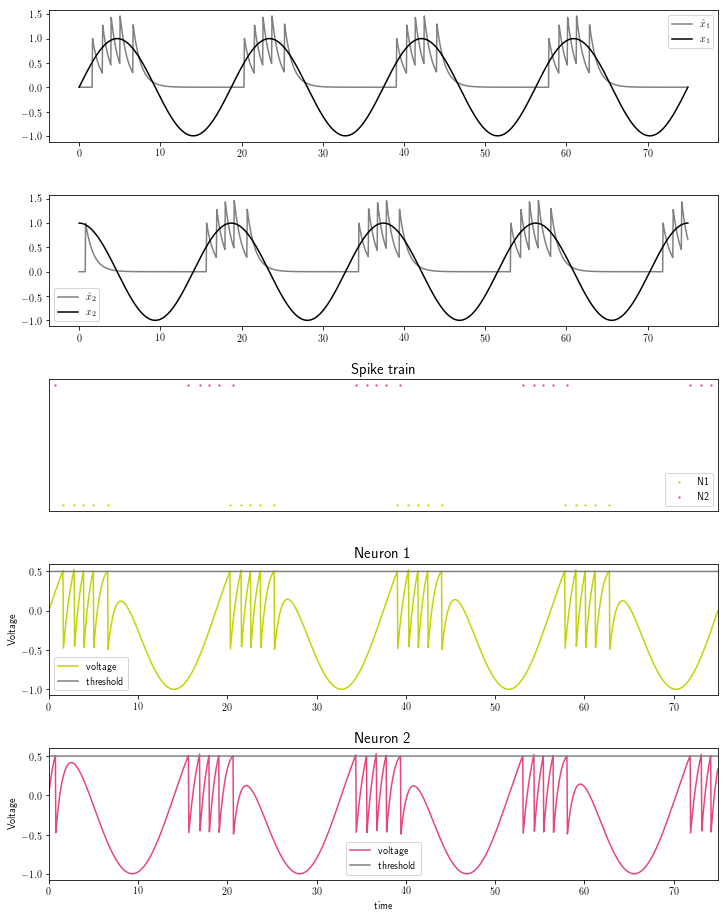

In [196]:
# Run simulation and plot results for given parameters
N = 2                                                    # number of neurons
d = 2                                                    # number of dimensions of signal input
dt = 0.05                                                 # step size
iterations = 1500                                         # number of time steps
c_upp = 1                                                # input value
tau = 1                                                  # time constant
beta = 0.0                                               # cost 
color = np.random.randint(0, 255, size=(N, 3))           # color map for plotting the different neurons
positive_signal = False

# run simulation
D = initialize_weights(N, d)                                                # initialize decoding weights
D[0][0] = 1
D[0][1] = 0
D[1][1] = 1
D[1][0] = 0
t, voltage, x_est, o, T = initialize_params(N, d, dt, iterations, D, beta)  # initialize parameters
c, x = time_varying_signal(d, positive_signal=positive_signal)              # create d-dimensional input signal
#c, x = time_varying_signal_plateau(c_upp)                                  # create d-dimensional input signal
run(tau, beta)                                                              # run spiking network
visualize(color, plot_voltage=True)                                         # plot results

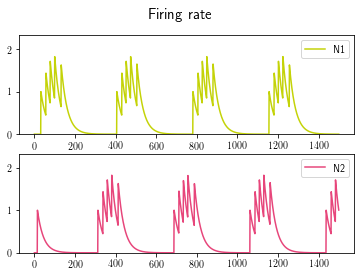

In [198]:
visualize_firing_rate()

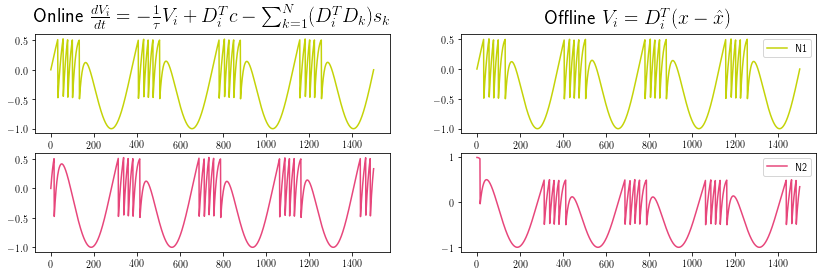

In [199]:
voltage_offline = visualize_voltage()

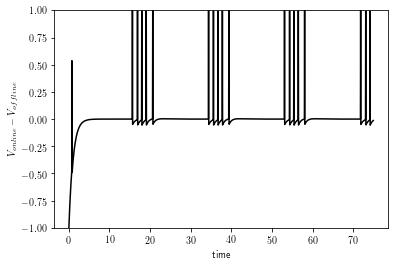

In [200]:
neuron = 2
if neuron < 1 or neuron > N:
    print("Enter valid neuron")
else:
    plot_voltage_diff(voltage[neuron - 1, :], voltage_offline[neuron - 1, :])

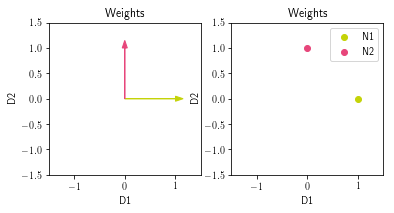

In [201]:
plot_weights()

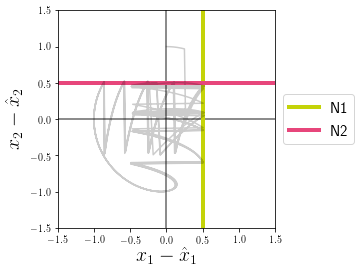

In [203]:
plot_error_space(plot_error=True)

In [204]:
D

array([[1., 0.],
       [0., 1.]])

MovieWriter imagemagick unavailable. Trying to use pillow instead.


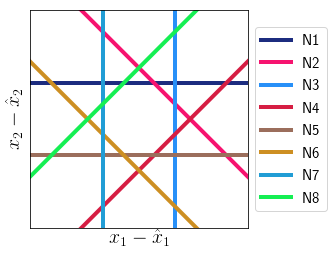

In [63]:
fig = bounding_box_animation_2D(iterations)

MovieWriter imagemagick unavailable. Trying to use pillow instead.


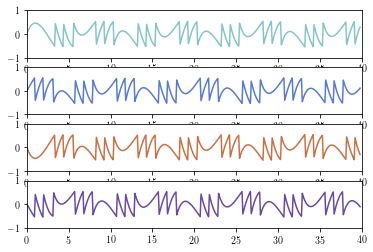

In [86]:
def voltages_animation_2D(frames, interval=70):
    """ Plot animation of the coding error through time with respect to the bounding box.
    
    Parameters
    ----------
    frames: int
        number of frames
    interval: int, optional
        time between frames
    
    """
    
    if d == 2:
        
        # file
        file = 'C:/Users/amber/MachensLab/BoundingBox/voltages/D' + str(d) + '_N' + str(N) + '_voltages.gif'

        # initiate plots
        fig, axes = pl.subplots(N,1)
        point = []
        
        for i in range(N):
            # set axes
            axes[i].set_ylim(-1, 1)
            axes[i].set_xlim(0, iterations * dt)
            
            temp, = axes[i].plot([], [], color=color[i][:]/255)
            point.append(temp)
        
        def animate(i):
            
            # update the data
            x = t[0:i]
            
            # set y data
            for n in range(N):
                y = voltage[n, 0:i]
                point[n].set_data(x, y)
            
            return point

        # runs animation
        ani = animation.FuncAnimation(fig, animate, frames=frames, interval=interval, blit=True)
        ani.save(file, writer='imagemagick') # save as .gif
        pl.show()
        
        return fig
        
    else:
        print("2D signal input only.")
        
fig = voltages_animation_2D(iterations)